In [3]:
# Brain Tumor Segmentation (BraTS) — LoG filter -> 3D U-Net with Evaluation
# Corrected, robust, ready-to-run Kaggle notebook/script.
# Fixes included:
# - Robust globbing for .nii and .nii.gz files
# - Skip cases missing any modality or segmentation (prints which are skipped)
# - Cache check for both x and y .npy files
# - Safe preprocessing loop (doesn't crash on missing files)
# - Clean evaluation and predict function

import os
import sys
import glob
from pathlib import Path
import numpy as np
import nibabel as nib
from scipy import ndimage as ndi
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tqdm import tqdm

# -------------------- CONFIG --------------------
DATA_DIR = '/kaggle/input/braindata/MICCAI_BraTS2020_TrainingData'
PREPROCESS_DIR = '/kaggle/working/preprocessed_npy'
Path(PREPROCESS_DIR).mkdir(parents=True, exist_ok=True)

TARGET_SHAPE = (128, 128, 128)
MODALITIES = ["flair", "t1", "t1ce", "t2"]
N_CHANNELS = len(MODALITIES)
EPOCHS = 300
PATIENCE = 20
SEED = 42
BATCH_SIZE = 1

# -------------------- UTILS --------------------

def list_case_dirs(data_dir):
    # Return only top-level case folders matching the pattern
    base = Path(data_dir)
    cases = sorted([str(p) for p in base.glob('BraTS20_Training_*') if p.is_dir()])
    return cases


def load_nifti(path):
    img = nib.load(str(path))
    return img.get_fdata(dtype=np.float32), img.affine


def resample_volume(vol, target_shape):
    if vol.ndim != 3:
        raise ValueError(f"Expected 3D volume, got shape {vol.shape}")
    zoom = [t / float(s) for s, t in zip(vol.shape, target_shape)]
    return ndi.zoom(vol, zoom, order=1)


def normalize_intensity(vol):
    mask = vol > 0
    if np.any(mask):
        v = vol[mask]
        return (vol - v.mean()) / (v.std() + 1e-8)
    else:
        return vol


def apply_log(vol, sigma=1.0):
    return normalize_intensity(ndi.gaussian_laplace(vol, sigma=sigma))

# -------------------- PREPROCESS --------------------

def find_file(case_dir, pattern):
    """Find first file matching pattern (supports .nii and .nii.gz). Returns Path or None."""
    files = list(Path(case_dir).glob(pattern))
    if not files:
        # try with .nii.gz explicit
        files = list(Path(case_dir).glob(pattern + '.gz'))
    return files[0] if files else None


def preprocess_case(case_dir, cache_dir=PREPROCESS_DIR, target_shape=TARGET_SHAPE, sigma=1.0):
    case_name = Path(case_dir).name
    x_out = Path(cache_dir) / f"{case_name}_x.npy"
    y_out = Path(cache_dir) / f"{case_name}_y.npy"

    # If both cached, return immediately
    if x_out.exists() and y_out.exists():
        return str(x_out), str(y_out)

    channels = []
    for m in MODALITIES:
        # match either *_flair.nii or *_flair.nii.gz
        f = find_file(case_dir, f'*{m}.nii*')
        if f is None:
            print(f"⚠️  Missing modality '{m}' for {case_name}. Skipping case.")
            return None
        vol, _ = load_nifti(f)
        try:
            vol = resample_volume(vol, target_shape)
        except Exception as e:
            print(f"⚠️  Resample failed for {case_name} modality {m}: {e}. Skipping.")
            return None
        vol = normalize_intensity(vol)
        vol = apply_log(vol, sigma=sigma)
        channels.append(vol)

    x = np.stack(channels, axis=-1).astype(np.float32)

    seg = find_file(case_dir, '*_seg.nii*')
    if seg is None:
        print(f"⚠️  Missing segmentation for {case_name}. Skipping case.")
        return None
    y, _ = load_nifti(seg)
    try:
        y = resample_volume(y, target_shape)
    except Exception as e:
        print(f"⚠️  Resample failed for segmentation of {case_name}: {e}. Skipping.")
        return None
    y = (y > 0).astype(np.float32)
    y = np.expand_dims(y, axis=-1)

    np.save(x_out, x)
    np.save(y_out, y)
    return str(x_out), str(y_out)

# -------------------- PREPROCESS ALL CASES (with safe skipping) --------------------

cases = list_case_dirs(DATA_DIR)
print(f"Found {len(cases)} case folders. Beginning preprocessing...")
preprocessed = []
for c in tqdm(cases):
    res = preprocess_case(c)
    if res is not None:
        preprocessed.append(res)

if len(preprocessed) == 0:
    raise RuntimeError('No valid preprocessed cases found. Check your DATA_DIR and file naming.')

x_paths = [p[0] for p in preprocessed]
y_paths = [p[1] for p in preprocessed]

train_x, val_x, train_y, val_y = train_test_split(x_paths, y_paths, test_size=0.1, random_state=SEED)
print(f"Prepared dataset -> train: {len(train_x)}, val: {len(val_x)}")

# -------------------- DATA PIPELINE --------------------

def _load(x, y):
    x = np.load(x.decode('utf-8'))
    y = np.load(y.decode('utf-8'))
    return x, y


def tf_load(x, y):
    x, y = tf.numpy_function(_load, [x, y], [tf.float32, tf.float32])
    x.set_shape(list(target_shape := list(TARGET_SHAPE)) + [N_CHANNELS])
    y.set_shape(list(target_shape) + [1])
    return x, y

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(len(train_x), seed=SEED)
train_ds = train_ds.map(tf_load, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_x, val_y))
val_ds = val_ds.map(tf_load, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# -------------------- MODEL --------------------

def conv_block(x, f):
    x = layers.Conv3D(f, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(f, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x


def unet3d(input_shape=(128,128,128,4)):
    i = layers.Input(input_shape)
    c1 = conv_block(i,16); p1 = layers.MaxPool3D(2)(c1)
    c2 = conv_block(p1,32); p2 = layers.MaxPool3D(2)(c2)
    c3 = conv_block(p2,64); p3 = layers.MaxPool3D(2)(c3)
    c4 = conv_block(p3,128); p4 = layers.MaxPool3D(2)(c4)
    bn = conv_block(p4,256)
    u4 = layers.UpSampling3D(2)(bn); u4 = layers.Concatenate()([u4,c4]); c5 = conv_block(u4,128)
    u3 = layers.UpSampling3D(2)(c5); u3 = layers.Concatenate()([u3,c3]); c6 = conv_block(u3,64)
    u2 = layers.UpSampling3D(2)(c6); u2 = layers.Concatenate()([u2,c2]); c7 = conv_block(u2,32)
    u1 = layers.UpSampling3D(2)(c7); u1 = layers.Concatenate()([u1,c1]); c8 = conv_block(u1,16)
    o = layers.Conv3D(1,1,activation='sigmoid')(c8)
    return models.Model(i,o)


def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f, y_pred_f = K.flatten(y_true), K.flatten(y_pred)
    inter = K.sum(y_true_f*y_pred_f)
    return (2*inter+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)+smooth)


def dice_loss(y_true,y_pred):
    return 1-dice_coef(y_true,y_pred)


def combo_loss(y_true,y_pred):
    return tf.keras.losses.binary_crossentropy(y_true,y_pred)+dice_loss(y_true,y_pred)

model = unet3d(TARGET_SHAPE+(N_CHANNELS,))
model.compile(optimizer='adam',loss=combo_loss,metrics=[dice_coef, tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary()

ckpt = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/best_unet3d.h5',save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(patience=PATIENCE,restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=6,verbose=1)

# -------------------- TRAIN --------------------

history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS,callbacks=[ckpt,stop,reduce_lr])
model.save('/kaggle/working/final_unet3d')

# -------------------- EVALUATION --------------------

print("Evaluating model on validation set...")
# evaluate returns [loss, dice, meanIoU]
val_metrics = model.evaluate(val_ds)
print(f"Validation Results -> Loss: {val_metrics[0]:.4f}, Dice: {val_metrics[1]:.4f}, MeanIoU: {val_metrics[2]:.4f}")

# Additional metrics computed per-case (Dice, IoU, Precision, Recall, Accuracy)
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

metrics_list = []
for x_path, y_path in zip(val_x, val_y):
    x = np.load(x_path)
    y = np.load(y_path)
    pred = model.predict(np.expand_dims(x,0))[0,...,0]
    pred_bin = (pred >= 0.5).astype(np.uint8).ravel()
    y_bin = (y[...,0] >= 0.5).astype(np.uint8).ravel()
    # avoid degenerate cases for sklearn by checking sum
    if y_bin.sum() == 0 and pred_bin.sum() == 0:
        dice = 1.0
        iou = 1.0
        prec = 1.0
        rec = 1.0
        acc = 1.0
    else:
        # compute metrics
        tp = np.logical_and(y_bin==1, pred_bin==1).sum()
        fp = np.logical_and(y_bin==0, pred_bin==1).sum()
        fn = np.logical_and(y_bin==1, pred_bin==0).sum()
        dice = (2*tp) / (2*tp + fp + fn + 1e-8)
        iou = tp / (tp + fp + fn + 1e-8)
        prec = tp / (tp + fp + 1e-8)
        rec = tp / (tp + fn + 1e-8)
        acc = (tp + (y_bin.size - (tp+fp+fn))) / y_bin.size

    metrics_list.append({'case': Path(x_path).stem.replace('_x',''), 'dice': float(dice), 'iou': float(iou), 'precision': float(prec), 'recall': float(rec), 'accuracy': float(acc)})

# Save metrics to CSV
import pandas as pd
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv('/kaggle/working/validation_metrics.csv', index=False)
print('Saved per-case validation metrics to /kaggle/working/validation_metrics.csv')
print(metrics_df.describe())

# -------------------- PREDICT SINGLE CASE (robust) --------------------

def predict_case(case_dir, model, out_path='/kaggle/working/predicted_mask.nii.gz'):
    channels = []
    for m in MODALITIES:
        f = find_file(case_dir, f'*{m}.nii*')
        if f is None:
            raise RuntimeError(f"Modality {m} missing for {case_dir}")
        vol, aff = load_nifti(f)
        vol = resample_volume(vol, TARGET_SHAPE)
        vol = normalize_intensity(vol)
        vol = apply_log(vol)
        channels.append(vol)
    x = np.stack(channels, axis=-1).astype(np.float32)[None,...]
    pred = model.predict(x)[0,...,0]
    pred_bin = (pred >= 0.5).astype(np.uint8)
    # use affine of first modality if available
    nib.save(nib.Nifti1Image(pred_bin, aff if 'aff' in locals() else np.eye(4)), out_path)
    print(f'Saved predicted mask to {out_path}')
    return pred, pred_bin

print("Pipeline completed successfully.")

2025-10-08 15:41:48.378105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759938108.581023      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759938108.640899      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 369 case folders. Beginning preprocessing...


 96%|█████████▌| 355/369 [15:08<00:43,  3.13s/it]

⚠️  Missing segmentation for BraTS20_Training_355. Skipping case.


100%|██████████| 369/369 [15:53<00:00,  2.58s/it]
I0000 00:00:1759939074.695779      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


Prepared dataset -> train: 331, val: 37


I0000 00:00:1759939074.697590      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: (<gast.gast.NamedExpr object at 0x7b8d8c0a8c70>, (target_shape := list(TARGET_SHAPE)))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 4)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 128, 128,  │      1,744 │ input_layer[0][0] │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │         64 │ conv3d[0][0]      │
│ (BatchNormalizatio… │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 128, 128,  │      6,928 │ batch_normalizat… │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 64, 64,    │     13,856 │ max_pooling3d[0]… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 64, 64,    │     27,680 │ batch_normalizat… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv3d_3[0][0]    │
│ (BatchNormalizatio… │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 32, 32,    │     55,360 │ max_pooling3d_1[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv3d_4[0][0]    │
│ (BatchNormalizatio… │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 32, 32,    │    110,656 │ batch_normalizat… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv3d_5[0][0]    │
│ (BatchNormalizatio… │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 16, 16,    │    221,312 │ max_pooling3d_2[

 Total params: 5,891,217 (22.47 MB)

 Trainable params: 5,888,273 (22.46 MB)

 Non-trainable params: 2,944 (11.50 KB)

Epoch 1/300


I0000 00:00:1759939094.928560     105 service.cc:148] XLA service 0x7b8cd423f1e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759939094.929866     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759939094.929879     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759939097.269825     105 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1759939098.596034     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759939098.739398     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759939099.228251     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - dice_coef: 0.0753 - loss: 1.3788 - mean_io_u: 0.6314

E0000 00:00:1759939391.811362     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759939391.955302     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759939392.502613     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759939392.675443     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759939396.184953     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

331/331 ━━━━━━━━━━━━━━━━━━━━ 332s 831ms/step - dice_coef: 0.0755 - loss: 1.3780 - mean_io_u: 0.6316 - val_dice_coef: 0.0437 - val_loss: 66.8363 - val_mean_io_u: 0.2529 - learning_rate: 0.0010
Epoch 2/300
331/331 ━━━━━━━━━━━━━━━━━━━━ 269s 813ms/step - dice_coef: 0.6038 - loss: 0.4384 - mean_io_u: 0.7748 - val_dice_coef: 0.7188 - val_loss: 0.3310 - val_mean_io_u: 0.8443 - learning_rate: 0.0010
Epoch 3/300
331/331 ━━━━━━━━━━━━━━━━━━━━ 269s 811ms/step - dice_coef: 0.8008 - loss: 0.2233 - mean_io_u: 0.7507 - val_dice_coef: 0.7315 - val_loss: 0.2951 - val_mean_io_u: 0.7719 - learning_rate: 0.0010
Epoch 4/300
331/331 ━━━━━━━━━━━━━━━━━━━━ 269s 812ms/step - dice_coef: 0.8292 - loss: 0.1912 - mean_io_u: 0.7392 - val_dice_coef: 0.8133 - val_loss: 0.2242 - val_mean_io_u: 0.8598 - learning_rate: 0.0010
Epoch 5/300
331/331 ━━━━━━━━━━━━━━━━━━━━ 268s 810ms/step - dice_coef: 0.8268 - loss: 0.1976 - mean_io_u: 0.7565 - val_dice_coef: 0.8013 - val_loss: 0.3122 - val_mean_io_u: 0.8784 - learning_rate: 0.0

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/kaggle/working/final_unet3d.

In [4]:
model.save('/kaggle/working/final_unet3d.keras')


In [5]:
!ls -lh /kaggle/working/


total 136M
-rw-r--r-- 1 root root 68M Oct  8 17:46 best_unet3d.h5
-rw-r--r-- 1 root root 68M Oct  8 19:18 final_unet3d.keras
drwxr-xr-x 2 root root 36K Oct  8 15:57 preprocessed_npy


In [6]:
from tensorflow.keras.models import load_model

# Use the newer format if available
model = load_model("/kaggle/working/final_unet3d.keras",
                   custom_objects={'dice_coef': dice_coef,
                                   'dice_loss': dice_loss,
                                   'combo_loss': combo_loss})

print("✅ Model loaded successfully!")


✅ Model loaded successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 76 variables whereas the saved optimizer has 150 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [8]:
import matplotlib.pyplot as plt

def predict_case(case_dir, model):
    channels = []
    for m in MODALITIES:
        f = list(Path(case_dir).glob(f'*{m}.nii'))[0]
        vol, _ = load_nifti(f)
        vol = resample_volume(vol, TARGET_SHAPE)
        vol = apply_log(normalize_intensity(vol))
        channels.append(vol)
    x = np.stack(channels, -1)[None, ...]  # (1,128,128,128,4)
    pred = model.predict(x, verbose=1)[0, ..., 0]
    pred_bin = (pred > 0.5).astype(np.float32)
    nib.save(nib.Nifti1Image(pred_bin, np.eye(4)),
             '/kaggle/working/predicted_mask.nii.gz')
    print("🧾 Saved mask → /kaggle/working/predicted_mask.nii.gz")
    return pred_bin, channels[0]  # return FLAIR for visualization


✅ Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Saved predicted mask to /kaggle/working/pred_mask.nii.gz


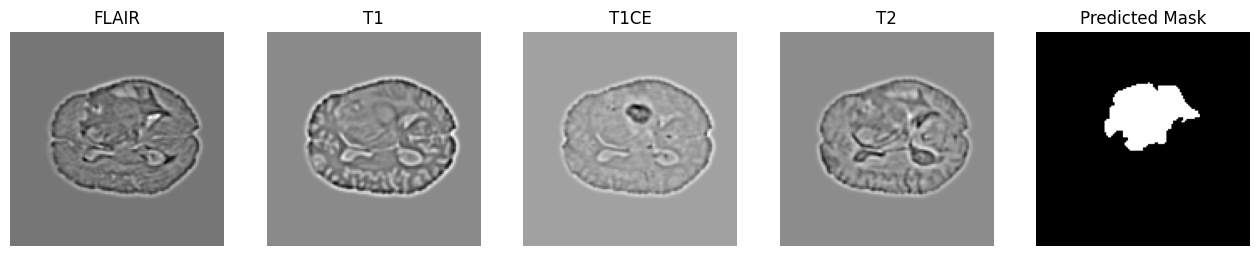

In [11]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import ndimage as ndi
import tensorflow as tf

# ---------------- CONFIG ----------------
MODALITIES = ["flair", "t1", "t1ce", "t2"]
TARGET_SHAPE = (128,128,128)

# ---------------- UTILS ----------------
def load_nifti(path):
    img = nib.load(str(path))
    return img.get_fdata(dtype=np.float32), img.affine

def resample_volume(vol, target_shape):
    zoom = [t / float(s) for s, t in zip(vol.shape, target_shape)]
    return ndi.zoom(vol, zoom, order=1)

def normalize_intensity(vol):
    mask = vol > 0
    if np.any(mask):
        v = vol[mask]
        return (vol - v.mean()) / (v.std() + 1e-8)
    else:
        return vol

def apply_log(vol, sigma=1.0):
    return normalize_intensity(ndi.gaussian_laplace(vol, sigma=sigma))

def find_file(case_dir, pattern):
    files = list(Path(case_dir).glob(pattern))
    if not files:
        files = list(Path(case_dir).glob(pattern+'.gz'))
    return files[0] if files else None

# ---------------- LOAD MODEL ----------------
model_path = '/kaggle/working/final_unet3d.keras'
model = tf.keras.models.load_model(model_path, compile=False)
print("✅ Model loaded successfully!")

# ---------------- PREDICT FUNCTION ----------------
def predict_case(case_dir, model, slice_idx=64, out_path='/kaggle/working/pred_mask.nii.gz'):
    channels = []
    for m in MODALITIES:
        f = find_file(case_dir, f'*{m}.nii*')
        if f is None:
            raise RuntimeError(f"Modality {m} missing for {case_dir}")
        vol, aff = load_nifti(f)
        vol = resample_volume(vol, TARGET_SHAPE)
        vol = normalize_intensity(vol)
        vol = apply_log(vol)
        channels.append(vol)
    
    x = np.stack(channels, axis=-1)[None,...]  # (1,128,128,128,4)
    pred = model.predict(x)[0,...,0]
    pred_bin = (pred >= 0.5).astype(np.uint8)
    
    # Save predicted mask
    nib.save(nib.Nifti1Image(pred_bin, aff if 'aff' in locals() else np.eye(4)), out_path)
    print(f"Saved predicted mask to {out_path}")
    
    # Visualization
    plt.figure(figsize=(16,4))
    for i, mod in enumerate(MODALITIES):
        plt.subplot(1,5,i+1)
        plt.imshow(x[0,:,:,slice_idx,i], cmap='gray')
        plt.title(mod.upper())
        plt.axis('off')
    
    plt.subplot(1,5,5)
    plt.imshow(pred_bin[:,:,slice_idx], cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')
    plt.show()

# ---------------- RUN ----------------
test_case = '/kaggle/input/braindata/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001'
predict_case(test_case, model)


✅ Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Saved predicted mask to /kaggle/working/pred_mask.nii.gz


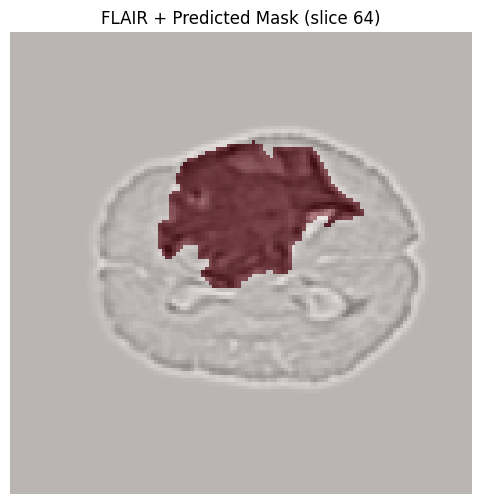

In [12]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import ndimage as ndi
import tensorflow as tf

# ---------------- CONFIG ----------------
MODALITIES = ["flair", "t1", "t1ce", "t2"]
TARGET_SHAPE = (128,128,128)

# ---------------- UTILS ----------------
def load_nifti(path):
    img = nib.load(str(path))
    return img.get_fdata(dtype=np.float32), img.affine

def resample_volume(vol, target_shape):
    zoom = [t / float(s) for s, t in zip(vol.shape, target_shape)]
    return ndi.zoom(vol, zoom, order=1)

def normalize_intensity(vol):
    mask = vol > 0
    if np.any(mask):
        v = vol[mask]
        return (vol - v.mean()) / (v.std() + 1e-8)
    else:
        return vol

def apply_log(vol, sigma=1.0):
    return normalize_intensity(ndi.gaussian_laplace(vol, sigma=sigma))

def find_file(case_dir, pattern):
    files = list(Path(case_dir).glob(pattern))
    if not files:
        files = list(Path(case_dir).glob(pattern+'.gz'))
    return files[0] if files else None

# ---------------- LOAD MODEL ----------------
model_path = '/kaggle/working/final_unet3d.keras'
model = tf.keras.models.load_model(model_path, compile=False)
print("✅ Model loaded successfully!")

# ---------------- PREDICT FUNCTION ----------------
def predict_case_overlay(case_dir, model, slice_idx=64, out_path='/kaggle/working/pred_mask.nii.gz'):
    channels = []
    for m in MODALITIES:
        f = find_file(case_dir, f'*{m}.nii*')
        if f is None:
            raise RuntimeError(f"Modality {m} missing for {case_dir}")
        vol, aff = load_nifti(f)
        vol = resample_volume(vol, TARGET_SHAPE)
        vol = normalize_intensity(vol)
        vol = apply_log(vol)
        channels.append(vol)
    
    x = np.stack(channels, axis=-1)[None,...]  # (1,128,128,128,4)
    pred = model.predict(x)[0,...,0]
    pred_bin = (pred >= 0.5).astype(np.uint8)
    
    # Save predicted mask
    nib.save(nib.Nifti1Image(pred_bin, aff if 'aff' in locals() else np.eye(4)), out_path)
    print(f"Saved predicted mask to {out_path}")
    
    # ---------------- VISUALIZATION ----------------
    flair_slice = x[0,:,:,slice_idx,0]
    mask_slice = pred_bin[:,:,slice_idx]
    
    plt.figure(figsize=(6,6))
    plt.imshow(flair_slice, cmap='gray')
    plt.imshow(mask_slice, cmap='Reds', alpha=0.5)  # red overlay
    plt.title(f"FLAIR + Predicted Mask (slice {slice_idx})")
    plt.axis('off')
    plt.show()

# ---------------- RUN ----------------
test_case = '/kaggle/input/braindata/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001'
predict_case_overlay(test_case, model)


In [13]:
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf

# -------------------- CONFIG --------------------
MODALITIES = ["flair", "t1", "t1ce", "t2"]
TARGET_SHAPE = (128, 128, 128)
N_CHANNELS = len(MODALITIES)

# Paths to validation data
val_x = sorted([str(p) for p in Path('/kaggle/working/preprocessed_npy').glob('*_x.npy')])
val_y = [str(p).replace('_x.npy', '_y.npy') for p in val_x]

# Load your trained model
model = tf.keras.models.load_model('/kaggle/working/best_unet3d.h5', compile=False)

# Re-compile with same loss/metrics for evaluation
from tensorflow.keras import backend as K
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f, y_pred_f = K.flatten(y_true), K.flatten(y_pred)
    inter = K.sum(y_true_f*y_pred_f)
    return (2*inter+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)+smooth)

def dice_loss(y_true,y_pred):
    return 1-dice_coef(y_true,y_pred)

def combo_loss(y_true,y_pred):
    return tf.keras.losses.binary_crossentropy(y_true,y_pred)+dice_loss(y_true,y_pred)

model.compile(optimizer='adam', loss=combo_loss, metrics=[dice_coef, tf.keras.metrics.MeanIoU(num_classes=2)])

# -------------------- PER-CASE EVALUATION --------------------
from sklearn.metrics import precision_score, recall_score, accuracy_score

metrics_list = []
for x_path, y_path in zip(val_x, val_y):
    x = np.load(x_path)
    y = np.load(y_path)
    pred = model.predict(np.expand_dims(x,0))[0,...,0]
    pred_bin = (pred >= 0.5).astype(np.uint8).ravel()
    y_bin = (y[...,0] >= 0.5).astype(np.uint8).ravel()
    
    # Avoid degenerate cases
    if y_bin.sum() == 0 and pred_bin.sum() == 0:
        dice = 1.0
        iou = 1.0
        prec = 1.0
        rec = 1.0
        acc = 1.0
    else:
        tp = np.logical_and(y_bin==1, pred_bin==1).sum()
        fp = np.logical_and(y_bin==0, pred_bin==1).sum()
        fn = np.logical_and(y_bin==1, pred_bin==0).sum()
        dice = (2*tp) / (2*tp + fp + fn + 1e-8)
        iou = tp / (tp + fp + fn + 1e-8)
        prec = tp / (tp + fp + 1e-8)
        rec = tp / (tp + fn + 1e-8)
        acc = (tp + (y_bin.size - (tp+fp+fn))) / y_bin.size

    metrics_list.append({
        'case': Path(x_path).stem.replace('_x',''),
        'dice': float(dice),
        'iou': float(iou),
        'precision': float(prec),
        'recall': float(rec),
        'accuracy': float(acc)
    })

metrics_df = pd.DataFrame(metrics_list)

# -------------------- PRINT PER-CASE METRICS --------------------
print("\nPer-case Metrics:\n")
print(metrics_df)

# -------------------- PRINT OVERALL STATISTICS --------------------
print("\nOverall Metrics (mean ± std):\n")
print(metrics_df.describe().loc[['mean','std']])


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 